# **C23-PR487 ~ LapakIn**

> **Assumption**  
> Successful MSMEs defined by: Rating >= 4 and Review >= 6 on Google Maps 

# Setup

In [146]:
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense

In [147]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/C23PR487/Capstone-Project/main/ML/successful_msme.csv')
df_raw = df_raw.sample(frac = 1)

# EDA & Preprocessing

In [148]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635 entries, 276 to 358
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   url                      635 non-null    object 
 1   nama toko                635 non-null    object 
 2   rating                   635 non-null    float64
 3   jumlah review            635 non-null    int64  
 4   kategori                 635 non-null    object 
 5   alamat                   635 non-null    object 
 6   kota                     635 non-null    object 
 7   jumlah mall terdekat     635 non-null    int64  
 8   jumlah kantor terdekat   635 non-null    int64  
 9   jumlah sekolah terdekat  635 non-null    int64  
 10  nama_mall                494 non-null    object 
 11  nama_kantor              454 non-null    object 
 12  nama_sekolah             581 non-null    object 
 13  label                    635 non-null    object 
dtypes: float64(1), int64(4),

In [149]:
df = df_raw[['jumlah mall terdekat', 'jumlah kantor terdekat', 'jumlah sekolah terdekat', 'label']]

In [150]:
df.head()

,jumlah mall terdekat,jumlah kantor terdekat,jumlah sekolah terdekat,label
276,2,1,7,usaha_fotokopi
585,6,3,12,usaha_fotokopi
480,0,2,2,usaha_laundry
416,0,0,3,toko_kopi
210,1,2,12,usaha_makanan


In [151]:
df.describe()

,jumlah mall terdekat,jumlah kantor terdekat,jumlah sekolah terdekat
count,635,635,635
mean,3,2,5
std,2,2,3
min,0,0,0
25%,1,0,2
50%,2,2,5
75%,4,4,7
max,13,12,16


## Check Duplicate

In [152]:
df_raw.duplicated().sum()

0

## Check Null Value

In [153]:
df.isnull().sum()

jumlah mall terdekat       0
jumlah kantor terdekat     0
jumlah sekolah terdekat    0
label                      0
dtype: int64

## Check Outlier

In [154]:
def compute_reasonable_bound(selected_attribute):
    Q1 = selected_attribute.quantile(0.25)
    Q3 = selected_attribute.quantile(0.75)
    IQR = Q3-Q1
    return [Q3 + (1.5*IQR), Q1 - (1.5*IQR)]
    
def compute_outliers(attribute, dataset):
    selected_attribute = dataset.sort_values(by=[attribute])[attribute]
    [RUB, RLB] = compute_reasonable_bound(selected_attribute)
    return len(dataset[(dataset[attribute] > RUB) | (dataset[attribute] < RLB)])

def check_outlier(dataset):
    attributes = []
    outliers = []
    for attribute in df:
        if dataset[attribute].dtype != 'O':
            many_outliers = compute_outliers(attribute, dataset)
            percentage_of_outlier = (many_outliers/len(dataset[attribute])) * 100
            attributes.append(attribute)
            outliers.append(percentage_of_outlier)

    data = {'attribute': attributes, 'percentage of outlier (%)': outliers}
    outlier_df = pd.DataFrame(data)
    return outlier_df

In [155]:
check_outlier(df)

,attribute,percentage of outlier (%)
0,jumlah mall terdekat,4
1,jumlah kantor terdekat,0
2,jumlah sekolah terdekat,1


## Encode Label

In [156]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

<ipython-input-156-895b4de63272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label_encoder.fit_transform(df['label'])


In [157]:
list(label_encoder.inverse_transform([0, 1, 2, 3, 4]))

['toko_kopi', 'usaha_baju', 'usaha_fotokopi', 'usaha_laundry', 'usaha_makanan']

In [158]:
joblib.dump(label_encoder, 'lapakin_encoder.pkl')

['lapakin_encoder.pkl']

## Split Data

In [159]:
X = df.drop(['label'],axis=1)
y = df['label']

In [160]:
# Get 80% of the dataset as the training set. Put the remaining 20% as cross validation set
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, random_state=1, shuffle=True)

## Normalize

In [161]:
X_train.describe()

,jumlah mall terdekat,jumlah kantor terdekat,jumlah sekolah terdekat
count,508,508,508
mean,3,2,5
std,2,2,3
min,0,0,0
25%,1,0,2
50%,2,2,5
75%,4,4,7
max,13,12,16


In [162]:
scaler = StandardScaler()
scaler.fit(X_train)

columns = ['jumlah mall terdekat', 'jumlah kantor terdekat', 'jumlah sekolah terdekat']
X_train = pd.DataFrame(scaler.transform(X_train), columns=columns)
X_cv = pd.DataFrame(scaler.transform(X_cv), columns=columns)

In [163]:
joblib.dump(scaler, 'lapakin_scaler.pkl')

['lapakin_scaler.pkl']

# Modeling

In [164]:
model = Sequential(
    [
        Flatten(),
        Dense(400, activation = 'relu'),
        Dense(300, activation = 'relu'),
        Dense(250, activation = 'relu'),
        Dense(200, activation = 'relu'),
        Dense(100, activation = 'relu'),
        Dense(50, activation = 'relu'),
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(5, activation = 'linear')
    ]
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train, epochs=300
)

Epoch 1/300
16/16 [==============================] - 2s 14ms/step - loss: 1.6059 - accuracy: 0.2579
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 1.5827 - accuracy: 0.2539
Epoch 3/300
16/16 [==============================] - 0s 14ms/step - loss: 1.5754 - accuracy: 0.2638
Epoch 4/300
16/16 [==============================] - 0s 14ms/step - loss: 1.5681 - accuracy: 0.2677
Epoch 5/300
16/16 [==============================] - 0s 13ms/step - loss: 1.5488 - accuracy: 0.2776
Epoch 6/300
16/16 [==============================] - 0s 8ms/step - loss: 1.5401 - accuracy: 0.2677
Epoch 7/300
16/16 [==============================] - 0s 9ms/step - loss: 1.5422 - accuracy: 0.2854
Epoch 8/300
16/16 [==============================] - 0s 8ms/step - loss: 1.5302 - accuracy: 0.2677
Epoch 9/300
16/16 [==============================] - 0s 8ms/step - loss: 1.5238 - accuracy: 0.2933
Epoch 10/300
16/16 [==============================] - 0s 7ms/step - loss: 1.5111 - accuracy: 0.3012
Epoc

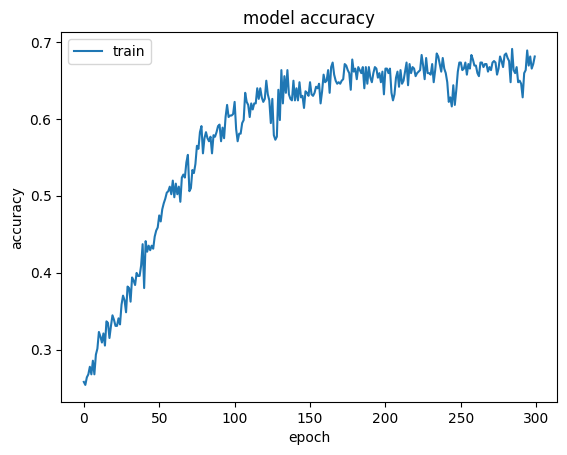

In [165]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

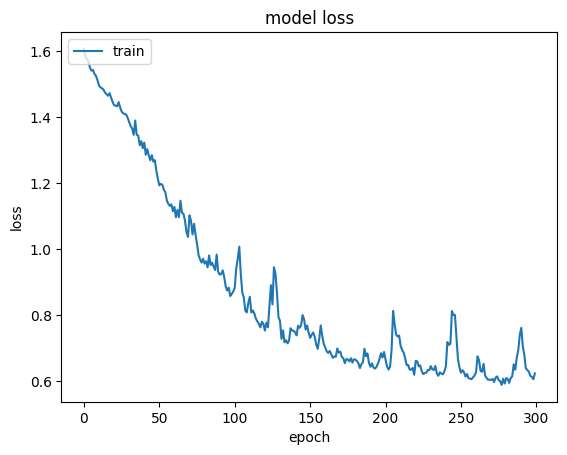

In [166]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [167]:
def get_predicted_label(y_result):
  rows = y_result.shape[0]
  y_pred = np.zeros(rows)
  for row in range(rows):
      y_pred[row] = np.argmax(y_result[row])
  return y_pred

In [168]:
y_result = model.predict(X_train)
y_pred = get_predicted_label(y_result)
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, y_pred) / 2}")

16/16 [==============================] - 0s 2ms/step
training MSE (using sklearn function): 0.9124015748031497


In [169]:
y_result = model.predict(X_cv)
y_pred = get_predicted_label(y_result)
print(f"cv MSE (using sklearn function): {mean_squared_error(y_cv, y_pred) / 2}")

4/4 [==============================] - 0s 3ms/step
cv MSE (using sklearn function): 2.188976377952756


In [170]:
model.save('lapakin_model.h5')

# Prediction

In [171]:
import numpy as np
import pandas as pd
import joblib
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from json import loads, dumps

def get_predicted_label(y_result):
  rows = y_result.shape[0]
  y_pred = np.zeros(rows)
  for row in range(rows):
      y_pred[row] = np.argmax(y_result[row])
  return y_pred

def convert_to_json(df):
  result = df.to_json(orient="index")
  parsed = loads(result)
  return dumps(parsed, indent=4) 

model = load_model('./lapakin_model.h5')
scaler = joblib.load('lapakin_scaler.pkl') 
label_encoder = joblib.load('lapakin_encoder.pkl') 

# X_cv_new_sample = pd.DataFrame([[12, 11, 2],[11, 4, 2],[3, 8, 12]], columns = ['jumlah mall terdekat', 'jumlah kantor terdekat', 'jumlah sekolah terdekat'], dtype = float)
# X_cv_new_sample = scaler.transform(X_cv_new_sample)
# y_result_new_sample = model.predict(X_cv_new_sample)
# y_pred_new_sample = get_predicted_label(y_result_new_sample)
# print(y_pred_new_sample)

df_test = pd.read_csv('available_stall_test.csv', encoding= 'unicode_escape')
X_test = df_test[['jumlah mall terdekat', 'jumlah kantor terdekat', 'jumlah sekolah terdekat']]
X_test= scaler.transform(X_test)
y_test = model.predict(X_test)
df_test['label'] = label_encoder.inverse_transform(get_predicted_label(y_test).astype(int))

classified_stalls_json = convert_to_json(df_test)

1/1 [==============================] - 0s 114ms/step


In [172]:
df_test

,url,gmaps,nama lapak,alamat,kecamatan,kota,harga,jumlah mall terdekat,jumlah kantor terdekat,jumlah sekolah terdekat,penjual/agen,kontak,label,deskripsi,luas bangunan,foto thumbnail
0,https://www.olx.co.id/item/lapak-jualan-strate...,https://www.google.com/maps/place/MRT+Blok+A/@...,LAPAK JUALAN STRATEGIS (KAWASAN PERTOKOAN & PE...,Jl. Pulo (Panglima Polim) Kebayoran baru (MRT ...,Kebayoran Baru,Jakarta Selatan,1500000,12,11,2,Vito,82113135672,usaha_makanan,"Disewakan lapak jualan\n\nPanglima Polim, Jaka...",8 m²,https://apollo-singapore.akamaized.net/v1/file...
1,https://www.olx.co.id/item/lapak-usaha-pasar-s...,https://www.google.com/maps/place/Santa+Modern...,Lapak Usaha Pasar Santa Kebayoran Baru,"Pasar Santa, Kebayoran Baru, Jakarta Selatan",Kebayoran Baru,Jakarta Selatan,500000,11,4,2,Arks,85716660005,usaha_makanan,HARGA SEWA TERMURAH!!!\n\nPasar Santa sendiri ...,2 m²,https://apollo-singapore.akamaized.net/v1/file...
2,https://www.olx.co.id/item/disewakan-lapak-unt...,https://www.google.com/maps/place/Refill+Parfu...,Disewakan Lapak untuk Gerobak di Pertigaan Str...,Jl. Sirsak Ujung Pertigaan Jagakarsa 1 Ciganju...,Jagakarsa,Jakarta Selatan,850000,3,8,12,Niyoula,NaN,usaha_laundry,Disewakan Lapak untuk Gerobak di Pertigaan Str...,2 m²,https://apollo-singapore.akamaized.net/v1/file...


In [173]:
classified_stalls_json

'{\n    "0": {\n        "url": "https://www.olx.co.id/item/lapak-jualan-strategis-kawasan-pertokoan-perkantoran-iid-890814401",\n        "gmaps": "https://www.google.com/maps/place/MRT+Blok+A/@-6.2557533,106.7952401,18z/data=!4m10!1m2!2m1!1sJl.+Pulo+(Panglima+Polim)+Kebayoran+baru+(MRT+Blok+A)!3m6!1s0x2e69f174f7c27a25:0x8af8a4e5adfcd1ba!8m2!3d-6.2557533!4d106.7971347!15sCjVKbC4gUHVsbyAoUGFuZ2xpbWEgUG9saW0pIEtlYmF5b3JhbiBiYXJ1IChNUlQgQmxvayBBKVoyIjBqbCBwdWxvIHBhbmdsaW1hIHBvbGltIGtlYmF5b3JhbiBiYXJ1IG1ydCBibG9rIGGSAQ5zdWJ3YXlfc3RhdGlvbpoBI0NoWkRTVWhOTUc5blMwVkpRMEZuU1VSbGJsOXRNVXRCRUFF4AEA!16s%2Fg%2F11fx8wlw4_?entry=ttu",\n        "nama lapak": "LAPAK JUALAN STRATEGIS (KAWASAN PERTOKOAN & PERKANTORAN)",\n        "alamat": "Jl. Pulo (Panglima Polim) Kebayoran baru (MRT Blok A)",\n        "kecamatan": "Kebayoran Baru",\n        "kota": "Jakarta Selatan",\n        "harga": 1500000,\n        "jumlah mall terdekat": 12,\n        "jumlah kantor terdekat": 11,\n        "jumlah sekolah terdekat":